In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
from tqdm import tqdm
import torch
from torch.distributions import MultivariateNormal

from sbi.inference import SNPE
from sbi.utils import BoxUniform
import sbibm

from lf2i.inference import LF2I
from lf2i.test_statistics.posterior import Posterior
from lf2i.utils.other_methods import hpd_region
from lf2i.plot.parameter_regions import plot_parameter_regions

from utils import posterior_and_prior_kdeplot

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [6]:
POI_DIM = 2  # parameter of interest
PRIOR_LOC = [0, 0]
PRIOR_VAR = 2.0

FLOW_TYPE = 'snpe-maf'
B = 100_000  # num simulations to estimate posterior and test statistics
B_PRIME = 30_000  # num simulations to estimate critical values
EVAL_GRID_SIZE = 50_000  # num evaluation points over parameter space to construct confidence sets
CONFIDENCE_LEVEL = 0.9

NORM_POSTERIOR_SAMPLES = None

DEVICE = 'cpu'
# for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [7]:
task = sbibm.get_task('gaussian_mixture')
prior = MultivariateNormal(
    loc=torch.Tensor(PRIOR_LOC), covariance_matrix=PRIOR_VAR*torch.eye(n=POI_DIM)
)
simulator = task.get_simulator()

In [8]:
b_params = prior.sample(sample_shape=(B, ))
b_samples = simulator(b_params.cpu())  # cast to cpu cause simulator does not appear to support GPU
b_params.shape, b_samples.shape

(torch.Size([100000, 2]), torch.Size([100000, 2]))

In [9]:
estimator = SNPE(
    prior=prior,
    device=DEVICE
)
_ = estimator.append_simulations(b_params, b_samples).train()
posterior = estimator.build_posterior()

 Neural network successfully converged after 102 epochs.

In [10]:
with open(f'./outputs/{FLOW_TYPE}_gaussPrior.pkl', 'wb') as f:
    pickle.dump(posterior, f)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

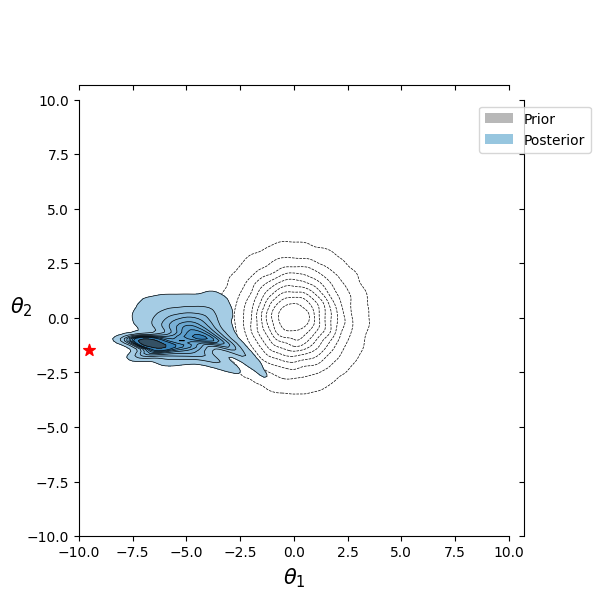

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

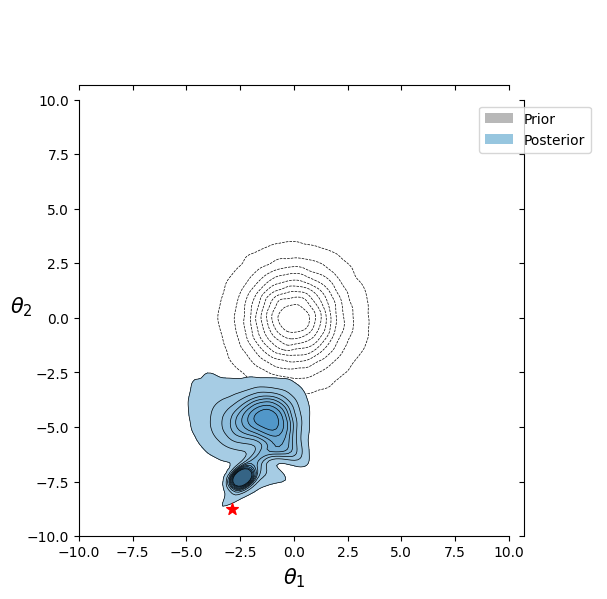

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

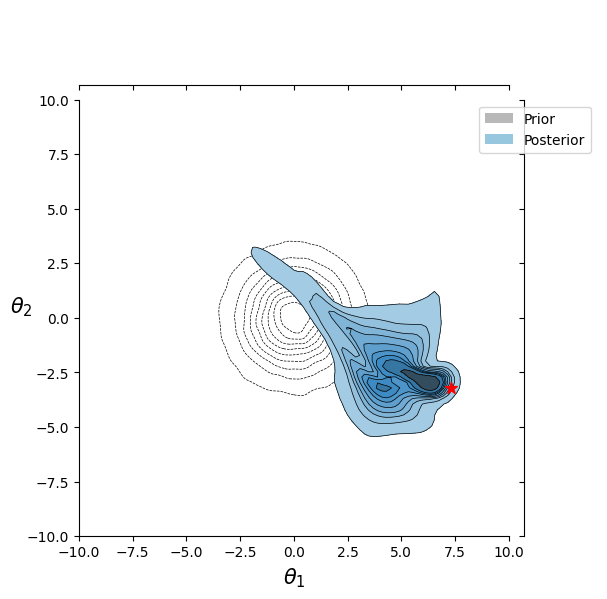

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

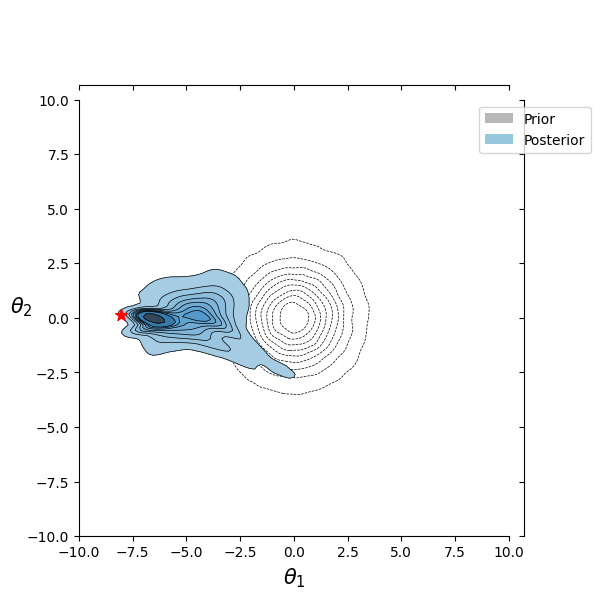

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

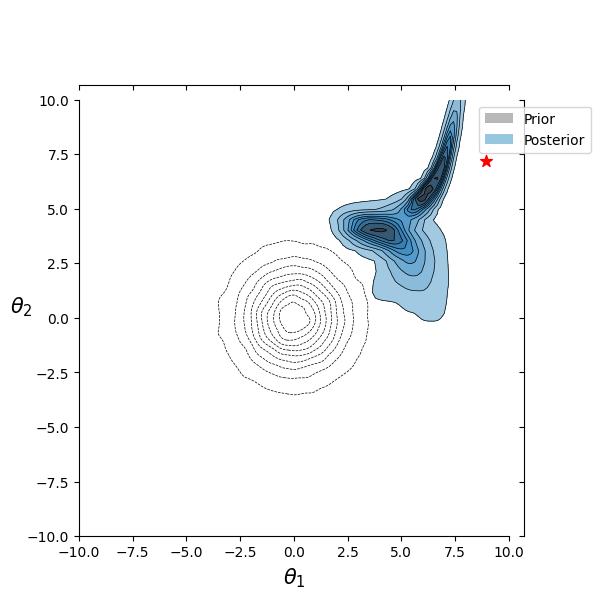

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

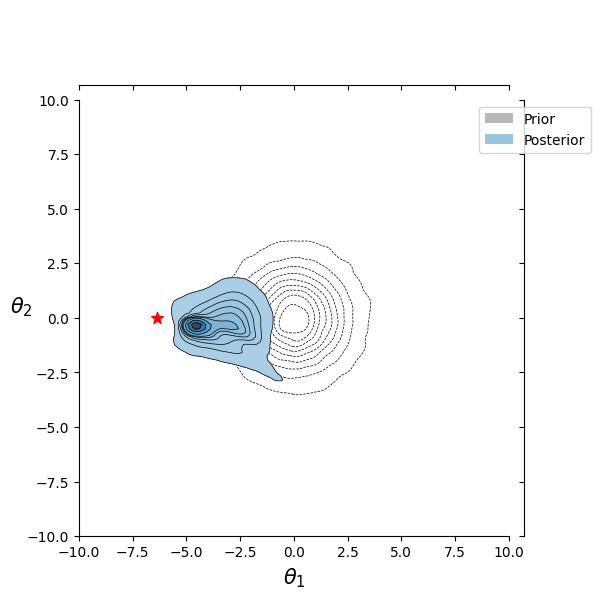

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

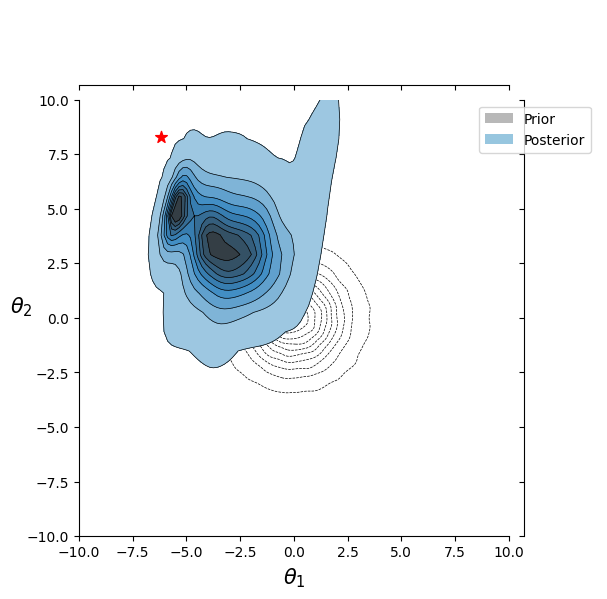

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

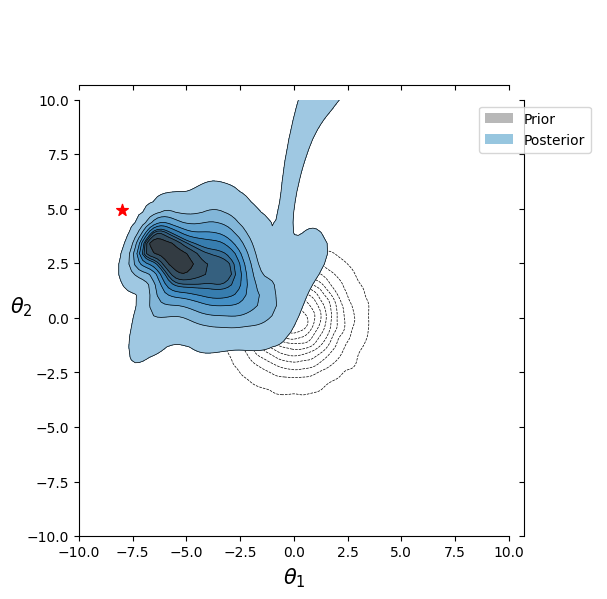

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

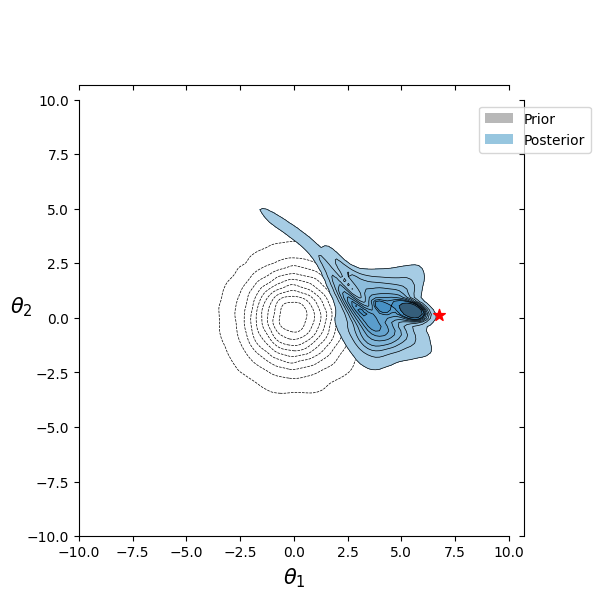

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

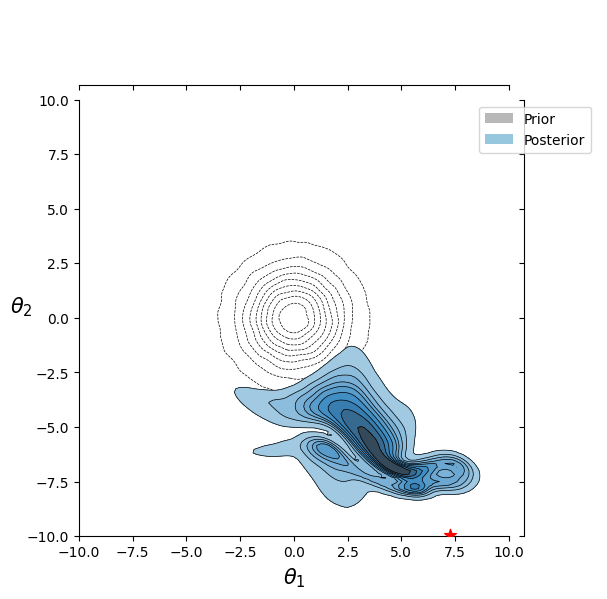

In [10]:
for idx_obs in range (1, 11):
    true_theta = task.get_true_parameters(idx_obs)
    true_x = task.get_observation(idx_obs)
    samples_posterior = posterior.sample((100_000,), x=true_x)
    samples_prior = prior.sample(sample_shape=(100_000, ))
    posterior_and_prior_kdeplot(
        samples_prior, samples_posterior, true_theta, plot_marginals=False
    )

## LF2I

In [11]:
# used to sample simulations for quantile regression and for evaluation grid
reference = BoxUniform(low=torch.Tensor([-10, -10]), high=torch.Tensor([10, 10]))
eval_grid = reference.sample(sample_shape=(EVAL_GRID_SIZE, ))

b_prime_params = reference.sample(sample_shape=(B_PRIME, ))
b_prime_samples = simulator(b_prime_params)
b_prime_params.shape, b_prime_samples.shape

(torch.Size([30000, 2]), torch.Size([30000, 2]))

In [12]:
lf2i = LF2I(
    test_statistic=Posterior(
        poi_dim=POI_DIM, estimator=posterior, norm_posterior_samples=NORM_POSTERIOR_SAMPLES
    )
)

In [13]:
confidence_sets = lf2i.inference(
    x=torch.vstack([task.get_observation(i) for i in range(1, 11)]),  # each task contains 10 benchmark observations
    evaluation_grid=eval_grid,
    confidence_level=CONFIDENCE_LEVEL,
    calibration_method='critical-values',
    calibration_model='cat-gb',
    calibration_model_kwargs={
        'cv': {'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 9]},
        'n_iter': 25
    },
    T_prime=(b_prime_params, b_prime_samples),
    retrain_calibration=False
)


Calibration ...


Evaluating posterior for 30000 points ...:   0%|          | 0/30000 [00:00<?, ?it/s]WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Evaluating posterior for 30000 points ...: 100%|██████████| 30000/30000 [00:21<00:00, 1410.10it/s

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Constructing confidence regions ...


Evaluating posterior for 10 points ...: 100%|██████████| 10/10 [00:00<00:00, 11.60it/s]


In [14]:
credible_regions = [
    hpd_region(
        posterior=lf2i.test_statistic.estimator,
        param_grid=eval_grid,
        x=task.get_observation(i), # x_obs[i, :],
        credible_level=CONFIDENCE_LEVEL,
        num_level_sets=10_000,
    )
    for i in tqdm(range(1, 11))
]

100%|██████████| 10/10 [00:01<00:00,  7.49it/s]


/Users/luca/Desktop/uni/cmu/research/vsi/lf2i/src/lf2i/plot/parameter_regions.py:154: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/Users/luca/Desktop/uni/cmu/research/vsi/lf2i/src/lf2i/plot/parameter_regions.py:154: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/Users/luca/Desktop/uni/cmu/research/vsi/lf2i/src/lf2i/plot/parameter_regions.py:154: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose 

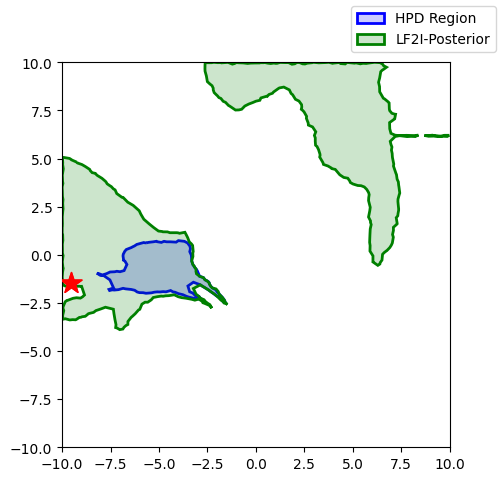

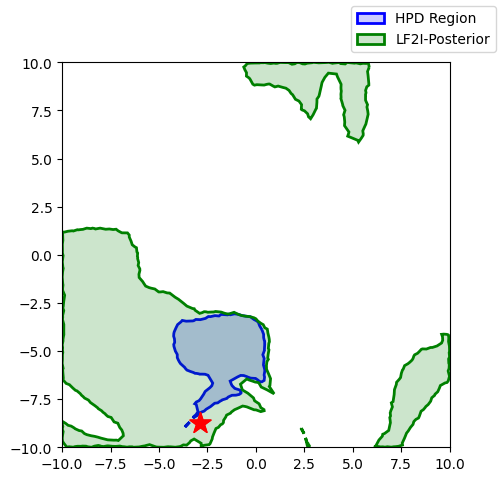

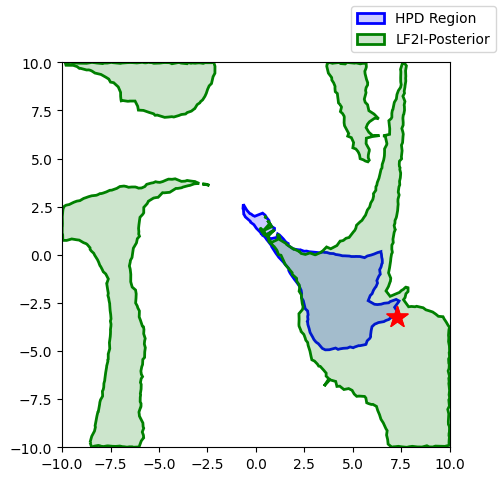

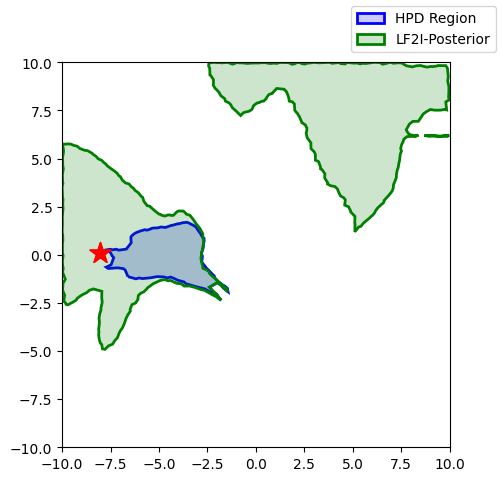

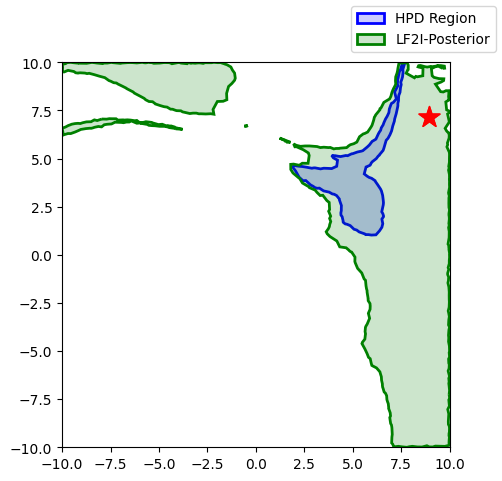

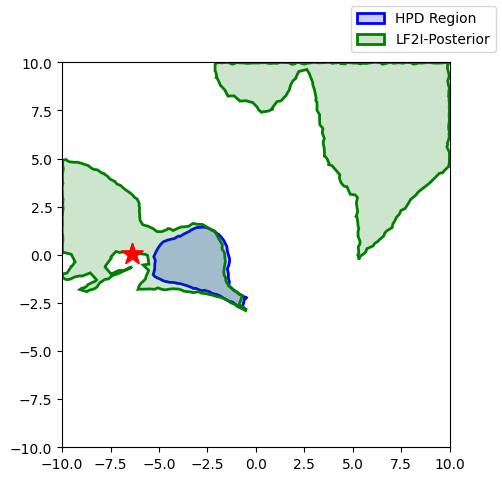

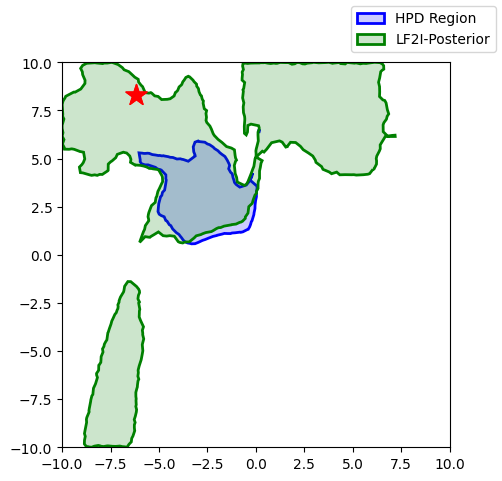

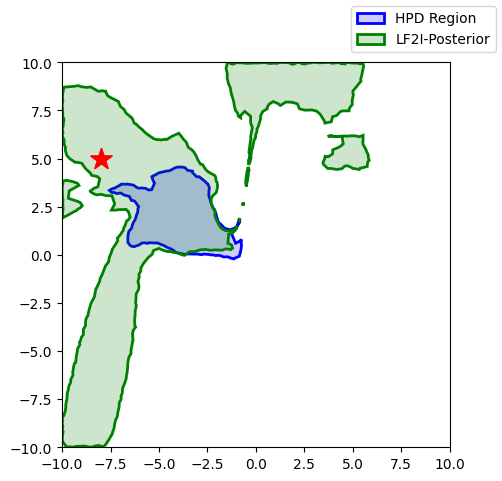

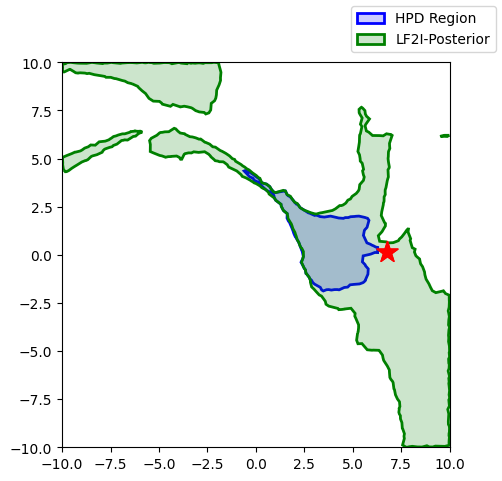

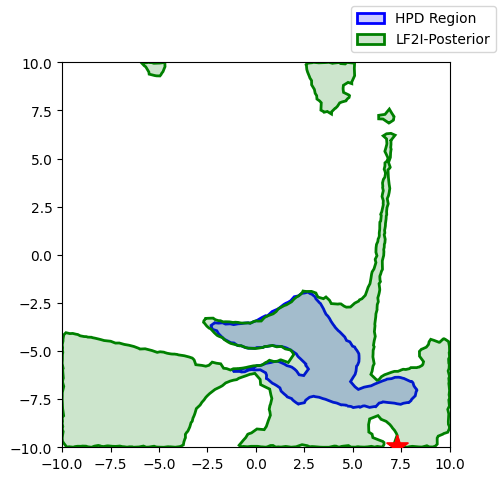

In [15]:
for idx_obs in range(1, 11):
    try:
        plot_parameter_regions(
            credible_regions[idx_obs-1][1], confidence_sets[idx_obs-1],
            param_dim=POI_DIM,
            true_parameter=task.get_true_parameters(idx_obs),
            parameter_space_bounds={r'$\theta_0$': {'low': -10, 'high': 10}, r'$\theta_1$': {'low': -10, 'high': 10}},
            region_names=['HPD Region', f'LF2I-Posterior'],
            param_names=[r'$\theta_0$', r'$\theta_1$'],
            labels=[r'$\theta_0$', r'$\theta_1$'],
            colors=['blue', 'green'],
            alpha_shape=True,
            alpha=4,
            scatter=False,
            figsize=(5, 5),
            #save_fig_path=f'../../results/figures/gaussian_mixture/nsf_maf_comparison/posterior_nsf_obs{idx_obs}.pdf'
        )
    except AttributeError:
        continue